# LSTM для определения тематики книги по названию

one-to-all

import json
import pandas as pd
import numpy as np

In [28]:
import nltk
import re
import pandas as pd
import numpy as np
from nltk.corpus import words, stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer, ISRIStemmer, LancasterStemmer, PorterStemmer, RegexpStemmer, RSLPStemmer, SnowballStemmer
from nltk.corpus import words as nltk_words

In [17]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import *
from sklearn.utils import resample # будем делать downsumpling


In [18]:
from gensim.models import Word2Vec, KeyedVectors
#w2v_model = Word2Vec.load('enwv\en.model')
w2v_model = KeyedVectors.load_word2vec_format('enwv\GoogleNews-vectors-negative300.bin', binary= True)

In [19]:
import collections

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Embedding, Dropout, Conv1D, Dense, Flatten, LSTM, Bidirectional
from keras.layers.pooling import GlobalMaxPool1D, MaxPooling1D, MaxPool1D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

In [20]:
#расширим список стоп-слов
## встречаются буквы по отдельности (окочания после апострофа и тп), возможно ошибки написания
mystopwords = set(stopwords.words('english') + ['a', 'b', 'c', 'd', 'e', 'f', 'j', 'h', 
           'g', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
           's', 't', 'u', 'v', 'w', 'x', 'y', 'z']) 

eng_let = ['a', 'b', 'c', 'd', 'e', 'f', 'j', 'h', 'i', 
           'g', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
           's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ']

In [21]:
lemm = WordNetLemmatizer()
def tokenize(x):
    article = re.compile(u'[a-z]+')    
    return article.findall(x)

def stop_words(x):
    return [token for token in x if not token in mystopwords]

def lemma(x):
    return [lemm.lemmatize(token) for token in x ]

In [22]:
books = pd.read_csv('title.csv')

C:\Users\blacat\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2,5,7,9,11,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
allbooks = len(books)
allbooks

58751

In [24]:
subj_list = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'recipes', 'religion', 'romance', 'science','science fiction']

In [25]:
# число книг с определенной темой
b_num = {}
for i in subj_list:
    books[i].sum()
    b_num[i] = books[i].sum()
b_num

#subj_sum = books.religion.sum()
#subj_sum

{'children': 4235.0,
 'fantasy': 4384.0,
 'medicine': 3144.0,
 'music': 6077.0,
 'mystery and detective stories': 2316.0,
 'recipes': 1225.0,
 'religion': 11098.0,
 'romance': 10181.0,
 'science': 13222.0,
 'science fiction': 3770.0}

создадим сбалансированную выборку:


In [29]:
#В словарях будем хранить информацию для всех классов;
Xtr_subj = {}
Xtst_subj = {}
ytr_subj = {}
ytst_subj = {}
vocab_sz_subj = {}
ebmedd_wts_subj = {}
maxlen_subj = {}


for subj in subj_list:
    print(subj)
    df_1 = books[['title','words',subj]][books[subj] == 1]
    df_majority = books[['title','words',subj]][books[subj] != 1]
    
    # Downsample majority class
    df_0 = resample(df_majority,replace=False,    # sample without replacement
                                 n_samples=int(b_num[subj]),     # to match minority class
                                 random_state=888) # reproducible results
    df_downsampl = pd.concat([df_0, df_1])
    df_downsampl.reset_index(inplace = True)
    del df_downsampl['index']
    X = df_downsampl['words']
    y = df_downsampl[subj]
    
    print(subj,'max sumples: ' + str(df_downsampl.shape))
    X_train, X_test, ytr, ytst = train_test_split(X, y, test_size=0.2, random_state=888, shuffle = True)
    
    ytr_bin = to_categorical(ytr)
    ytst_bin = to_categorical(ytst)
    ytr_subj[subj] = ytr_bin
    ytst_subj[subj] = ytst_bin
    
    counter = collections.Counter()
    maxlen = 0    
    for key, value in df_downsampl.title.items():
        title_words = stop_words(lemma(tokenize(value)))
        len_title = len(title_words)
        for w in title_words:
            counter[w] += 1
        if len_title>maxlen:
            maxlen = len_title
    maxlen_subj[subj] = maxlen
    all_w = len(counter) # число всех слов в названиях книг
    print('All words: ' + str(all_w) ,'. Max title length: '+ str(maxlen))
    
    VOCAB_SIZE = all_w #используем все слова для создания эмбеддингов для лучшего результата. 
    EMBED_SIZE = 300
    NUM_FILTERS = 256
    NUM_WORDS = 3
    BATCH_SIZE = 128
    NUM_EPOCHS = 20
    
    word2index = collections.defaultdict(int)
    for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
        word2index[word[0]] = wid
        vocab_sz = len(word2index) 
        index2word = {v:k for k, v in word2index.items()}
        
    vocab_sz_subj[subj] = vocab_sz
    print('Vocabular size: '+ str(vocab_sz))
    
    embedd_wts = np.zeros((vocab_sz, EMBED_SIZE))
    for word, index in word2index.items():
        #print(word, index)
        try:
            embedd_wts[index, :] = w2v_model[word]
        except KeyError:
            pass
    ebmedd_wts_subj[subj] = embedd_wts
    
    Xtrain, Xtest = [], []
    for i in X_train:
        title_words = stop_words(lemma(tokenize(i)))
        wids = [word2index[word] for word in title_words]
        Xtrain.append(wids)
    
    for i in X_test:
        title_words = stop_words(lemma(tokenize(i)))
        wids = [word2index[word] for word in title_words]
        Xtest.append(wids)
        
    Xtr = np.array(pad_sequences(Xtrain , maxlen = maxlen))
    Xtst = np.array(pad_sequences(Xtest, maxlen = maxlen)) 
    Xtr_subj[subj] = Xtr
    Xtst_subj[subj] = Xtst
    print();

children
children max sumples: (8470, 3)
All words: 8379 . Max title length: 21
Vocabular size: 8379

fantasy
fantasy max sumples: (8768, 3)
All words: 7960 . Max title length: 22
Vocabular size: 7960

medicine
medicine max sumples: (6288, 3)
All words: 7240 . Max title length: 41
Vocabular size: 7240

music
music max sumples: (12154, 3)
All words: 10888 . Max title length: 22
Vocabular size: 10888

mystery and detective stories
mystery and detective stories max sumples: (4632, 3)
All words: 5395 . Max title length: 22
Vocabular size: 5395

recipes
recipes max sumples: (2450, 3)
All words: 3204 . Max title length: 22
Vocabular size: 3204

religion
religion max sumples: (22196, 3)
All words: 15585 . Max title length: 26
Vocabular size: 15585

romance
romance max sumples: (20362, 3)
All words: 12737 . Max title length: 22
Vocabular size: 12737

science
science max sumples: (26444, 3)
All words: 17139 . Max title length: 26
Vocabular size: 17139

science fiction
science fiction max sumple

In [15]:
maxlen_subj

{'children': 21,
 'fantasy': 22,
 'medicine': 41,
 'music': 22,
 'mystery and detective stories': 22,
 'recipes': 22,
 'religion': 26,
 'romance': 22,
 'science': 26,
 'science fiction': 26}

# Реализация нейронной сети

LSTM

In [24]:
def title_model(vocab_sz, EMBED_SIZE, maxlen, embedd_wts):
    md = Sequential()
    md.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen, weights = [embedd_wts], trainable=False))
    md.add(LSTM(256, input_shape=(vocab_sz, EMBED_SIZE), return_sequences=True , activation= 'relu' ))
    md.add(Dropout(0.15))
    md.add(LSTM(128 , return_sequences=True , activation= 'relu' ))
    md.add(Dropout(0.15))
    md.add(LSTM(64, activation= 'relu' ))
    md.add(Dropout(0.15))
    md.add(Dense(1, activation= 'softmax'))
    optimizer = RMSprop(1e-4)
    md.compile(optimizer= optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
    return md

In [18]:
history_subj = {} # словарь сохранить историю вывода модели
predict_subj = {} # словарь хранить предсказания
preds_subj = {}

for subj in subj_list: 
    print(subj, vocab_sz_subj[subj], maxlen_subj[subj])
    
    checkp = ModelCheckpoint(filepath='title_weights\weights.best.title.'+ subj +'.hdf5', 
                               verbose=1, save_best_only=True)
    subj_process = title_model(vocab_sz_subj[subj], EMBED_SIZE, maxlen_subj[subj], \
                               ebmedd_wts_subj[subj]).fit(Xtr_subj[subj], ytr_subj[subj], 
                                                          batch_size = 256,
                                                          epochs=30, validation_split=0.15, 
                                                          callbacks=[checkp])
    history_subj[subj] = subj_process.history
    predict_subj[subj] = subj_process.model.predict_classes(Xtst_subj[subj], batch_size = BATCH_SIZE, verbose = 1)
    preds_subj[subj] = subj_process.model.predict_proba(Xtst_subj[subj], batch_size = 512)
    print();

children 8379 21
Train on 5759 samples, validate on 1017 samples
Epoch 1/35
5759/5759 [==============================] - 26s 4ms/step - loss: 0.6928 - acc: 0.5124 - val_loss: 0.6932 - val_acc: 0.4916
Epoch 2/35
5759/5759 [==============================] - 23s 4ms/step - loss: 0.6915 - acc: 0.5289 - val_loss: 0.6908 - val_acc: 0.5438
Epoch 3/35
5759/5759 [==============================] - 22s 4ms/step - loss: 0.6888 - acc: 0.5567 - val_loss: 0.6853 - val_acc: 0.6155
Epoch 4/35
5759/5759 [==============================] - 22s 4ms/step - loss: 0.6826 - acc: 0.5782 - val_loss: 0.6766 - val_acc: 0.5605
Epoch 5/35
5759/5759 [==============================] - 22s 4ms/step - loss: 0.6721 - acc: 0.5794 - val_loss: 0.6643 - val_acc: 0.5782
Epoch 6/35
5759/5759 [==============================] - 22s 4ms/step - loss: 0.6557 - acc: 0.6022 - val_loss: 0.6451 - val_acc: 0.5910
Epoch 7/35
5759/5759 [==============================] - 22s 4ms/step - loss: 0.6462 - acc: 0.6199 - val_loss: 0.6707 - val_ac

Epoch 29/35
5759/5759 [==============================] - 24s 4ms/step - loss: 0.4913 - acc: 0.7508 - val_loss: 0.5004 - val_acc: 0.7512
Epoch 30/35
5759/5759 [==============================] - 23s 4ms/step - loss: 0.4917 - acc: 0.7425 - val_loss: 0.4674 - val_acc: 0.7719
Epoch 31/35
5759/5759 [==============================] - 24s 4ms/step - loss: 0.4809 - acc: 0.7619 - val_loss: 0.5004 - val_acc: 0.7325
Epoch 32/35
5759/5759 [==============================] - 23s 4ms/step - loss: 0.4705 - acc: 0.7678 - val_loss: 0.4552 - val_acc: 0.7689
Epoch 33/35
5759/5759 [==============================] - 23s 4ms/step - loss: 0.4729 - acc: 0.7649 - val_loss: 0.4538 - val_acc: 0.7778
Epoch 34/35
5759/5759 [==============================] - 23s 4ms/step - loss: 0.4771 - acc: 0.7585 - val_loss: 0.4650 - val_acc: 0.7856
Epoch 35/35
1694/1694 [==============================] - 3s 2ms/step

fantasy 7960 22
Train on 5961 samples, validate on 1053 samples
Epoch 1/35
5961/5961 [============================

5961/5961 [==============================] - 25s 4ms/step - loss: 0.4899 - acc: 0.7526 - val_loss: 0.8755 - val_acc: 0.7075
Epoch 21/35
5961/5961 [==============================] - 25s 4ms/step - loss: 0.4919 - acc: 0.7537 - val_loss: 0.4958 - val_acc: 0.7550
Epoch 22/35
5961/5961 [==============================] - 27s 4ms/step - loss: 0.4804 - acc: 0.7584 - val_loss: 0.4959 - val_acc: 0.7464
Epoch 23/35
5961/5961 [==============================] - 25s 4ms/step - loss: 0.4745 - acc: 0.7707 - val_loss: 3.1854 - val_acc: 0.5812
Epoch 24/35
5961/5961 [==============================] - 25s 4ms/step - loss: 0.6081 - acc: 0.7609 - val_loss: 0.4724 - val_acc: 0.7664
Epoch 25/35
5961/5961 [==============================] - 26s 4ms/step - loss: 0.4614 - acc: 0.7727 - val_loss: 0.4900 - val_acc: 0.7578
Epoch 26/35
5961/5961 [==============================] - 25s 4ms/step - loss: 0.4627 - acc: 0.7734 - val_loss: 0.4741 - val_acc: 0.7645
Epoch 27/35
5961/5961 [==============================] - 24s

Epoch 6/35
8264/8264 [==============================] - 36s 4ms/step - loss: 0.6057 - acc: 0.6642 - val_loss: 2.4746 - val_acc: 0.5586
Epoch 7/35
8264/8264 [==============================] - 36s 4ms/step - loss: 0.6525 - acc: 0.6976 - val_loss: 0.5512 - val_acc: 0.7416
Epoch 8/35
8264/8264 [==============================] - 38s 5ms/step - loss: 0.5564 - acc: 0.7058 - val_loss: 0.5220 - val_acc: 0.7553
Epoch 9/35
8264/8264 [==============================] - 37s 4ms/step - loss: 0.5702 - acc: 0.6923 - val_loss: 0.6033 - val_acc: 0.6196
Epoch 10/35
8264/8264 [==============================] - 36s 4ms/step - loss: 0.5425 - acc: 0.7229 - val_loss: 0.5013 - val_acc: 0.7704
Epoch 11/35
8264/8264 [==============================] - 39s 5ms/step - loss: 0.5282 - acc: 0.7320 - val_loss: 0.5631 - val_acc: 0.7272
Epoch 12/35
8264/8264 [==============================] - 36s 4ms/step - loss: 0.5109 - acc: 0.7469 - val_loss: 0.5058 - val_acc: 0.7903
Epoch 13/35
8264/8264 [=============================

2431/2431 [==============================] - 4s 2ms/step

mystery and detective stories 5395 22
Train on 3149 samples, validate on 556 samples
Epoch 1/35
3149/3149 [==============================] - 17s 6ms/step - loss: 0.6919 - acc: 0.5249 - val_loss: 0.6902 - val_acc: 0.5252
Epoch 2/35
3149/3149 [==============================] - 13s 4ms/step - loss: 0.6893 - acc: 0.5532 - val_loss: 0.6870 - val_acc: 0.6133
Epoch 3/35
3149/3149 [==============================] - 13s 4ms/step - loss: 0.6863 - acc: 0.5907 - val_loss: 0.6808 - val_acc: 0.6331
Epoch 4/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.6788 - acc: 0.5856 - val_loss: 0.6656 - val_acc: 0.6295
Epoch 5/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.6663 - acc: 0.5856 - val_loss: 0.6518 - val_acc: 0.6151
Epoch 6/35
3149/3149 [==============================] - 13s 4ms/step - loss: 0.6523 - acc: 0.6002 - val_loss: 0.6422 - val_acc: 0.6205
Epoch 7/35
3149/3149 [=========================

Epoch 27/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.4895 - acc: 0.7513 - val_loss: 0.5072 - val_acc: 0.7338
Epoch 28/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.4827 - acc: 0.7628 - val_loss: 0.4749 - val_acc: 0.7878
Epoch 29/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.4619 - acc: 0.7780 - val_loss: 0.4757 - val_acc: 0.7770
Epoch 30/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.4659 - acc: 0.7723 - val_loss: 0.4448 - val_acc: 0.7824
Epoch 31/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.4630 - acc: 0.7755 - val_loss: 0.4929 - val_acc: 0.7770
Epoch 32/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.4675 - acc: 0.7704 - val_loss: 0.4674 - val_acc: 0.7590
Epoch 33/35
3149/3149 [==============================] - 12s 4ms/step - loss: 0.4560 - acc: 0.7748 - val_loss: 0.5078 - val_acc: 0.7626
Epoch 34/35
3149/3149 [=========================

Epoch 20/35
1666/1666 [==============================] - 8s 5ms/step - loss: 0.4508 - acc: 0.8097 - val_loss: 0.4619 - val_acc: 0.7483
Epoch 21/35
1666/1666 [==============================] - 8s 5ms/step - loss: 0.4736 - acc: 0.8067 - val_loss: 0.3564 - val_acc: 0.9048
Epoch 22/35
1666/1666 [==============================] - 7s 4ms/step - loss: 0.5126 - acc: 0.8163 - val_loss: 0.5070 - val_acc: 0.7483
Epoch 23/35
1666/1666 [==============================] - 7s 4ms/step - loss: 0.5033 - acc: 0.7653 - val_loss: 0.4481 - val_acc: 0.8299
Epoch 24/35
1666/1666 [==============================] - 7s 4ms/step - loss: 0.4680 - acc: 0.8169 - val_loss: 0.3853 - val_acc: 0.8810
Epoch 25/35
1666/1666 [==============================] - 7s 4ms/step - loss: 0.4015 - acc: 0.8451 - val_loss: 0.3726 - val_acc: 0.8095
Epoch 26/35
1666/1666 [==============================] - 8s 5ms/step - loss: 0.4219 - acc: 0.8103 - val_loss: 0.2527 - val_acc: 0.9184
Epoch 27/35
1666/1666 [==============================] 

Epoch 6/35
13845/13845 [==============================] - 69s 5ms/step - loss: 0.5357 - acc: 0.7229 - val_loss: 0.5366 - val_acc: 0.6980
Epoch 7/35
13845/13845 [==============================] - 68s 5ms/step - loss: 0.5135 - acc: 0.7398 - val_loss: 0.5074 - val_acc: 0.7565
Epoch 8/35
13845/13845 [==============================] - 67s 5ms/step - loss: 0.4874 - acc: 0.7481 - val_loss: 0.4977 - val_acc: 0.7745
Epoch 9/35
13845/13845 [==============================] - 68s 5ms/step - loss: 0.4756 - acc: 0.7634 - val_loss: 0.5247 - val_acc: 0.7103
Epoch 10/35
13845/13845 [==============================] - 64s 5ms/step - loss: 0.4617 - acc: 0.7725 - val_loss: 0.4775 - val_acc: 0.7660
Epoch 11/35
13845/13845 [==============================] - 65s 5ms/step - loss: 0.4605 - acc: 0.7761 - val_loss: 0.4463 - val_acc: 0.7852
Epoch 12/35
13845/13845 [==============================] - 59s 4ms/step - loss: 0.4429 - acc: 0.7854 - val_loss: 0.5365 - val_acc: 0.6935
Epoch 13/35
13845/13845 [=============

Epoch 26/35
17981/17981 [==============================] - 92s 5ms/step - loss: 0.3114 - acc: 0.8620 - val_loss: 0.3324 - val_acc: 0.8526
Epoch 27/35
17981/17981 [==============================] - 94s 5ms/step - loss: 0.3077 - acc: 0.8652 - val_loss: 0.3255 - val_acc: 0.8519
Epoch 28/35
17981/17981 [==============================] - 100s 6ms/step - loss: 0.3072 - acc: 0.8660 - val_loss: 0.3224 - val_acc: 0.8554
Epoch 29/35
17981/17981 [==============================] - 100s 6ms/step - loss: 0.3057 - acc: 0.8642 - val_loss: 0.3358 - val_acc: 0.8444
Epoch 30/35
17981/17981 [==============================] - 95s 5ms/step - loss: 0.3034 - acc: 0.8685 - val_loss: 0.3324 - val_acc: 0.8491
Epoch 31/35
17981/17981 [==============================] - 91s 5ms/step - loss: 0.3013 - acc: 0.8664 - val_loss: 0.3248 - val_acc: 0.8519
Epoch 32/35
17981/17981 [==============================] - 90s 5ms/step - loss: 0.2996 - acc: 0.8697 - val_loss: 0.3439 - val_acc: 0.8472
Epoch 33/35
17981/17981 [=======

In [21]:
ytst_subj[subj][:,1]

array([1., 1., 0., ..., 0., 1., 1.])

In [39]:
predict_subj[subj]

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [44]:
for subj in subj_list:
    print(subj)
    report = classification_report(ytst_subj[subj][:,1],predict_subj[subj])
    print(report)

children
             precision    recall  f1-score   support

        0.0       0.83      0.60      0.70       864
        1.0       0.68      0.87      0.76       830

avg / total       0.76      0.73      0.73      1694

fantasy
             precision    recall  f1-score   support

        0.0       0.73      0.83      0.78       872
        1.0       0.80      0.69      0.74       882

avg / total       0.77      0.76      0.76      1754

medicine
             precision    recall  f1-score   support

        0.0       0.77      0.88      0.82       638
        1.0       0.85      0.72      0.78       620

avg / total       0.81      0.80      0.80      1258

music
             precision    recall  f1-score   support

        0.0       0.80      0.88      0.84      1200
        1.0       0.87      0.78      0.82      1231

avg / total       0.83      0.83      0.83      2431

mystery and detective stories
             precision    recall  f1-score   support

        0.0       0.83  

In [2]:
import pickle 
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
books_proba = load_obj('books_probability')

In [6]:
from sklearn.metrics import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (11, 8)

In [36]:
fpr = {}
tpr = {}
thr = {}
roc_auc = {}
for subj in subj_list:
    fpr[subj] , tpr[subj] , thr[subj] = roc_curve(ytst_subj[subj][:,1],books_proba[subj][:,1])
    roc_auc[subj] = auc( fpr[subj], tpr[subj] )

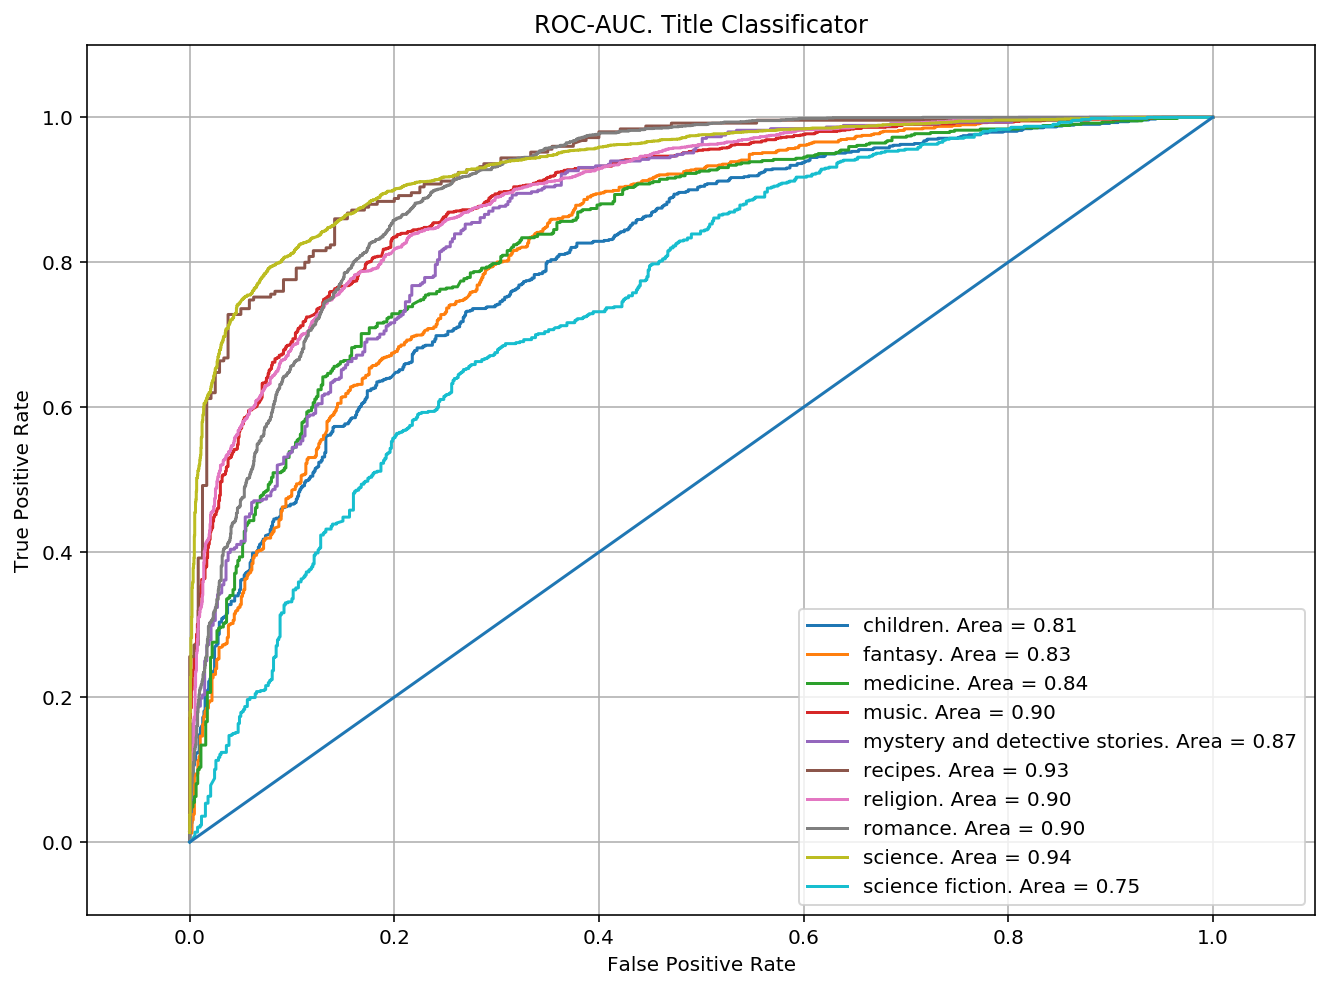

In [37]:
for subj in subj_list:
    plt.plot( fpr[subj], tpr[subj], label=subj +'. Area = {:.2f}'.format( roc_auc[subj]))       
    
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC. Title Classificator')
plt.legend(loc="lower right")
plt.savefig('ROC-AUC. Title Classificator.jpg', dpi =300)
plt.grid()
plt.show()

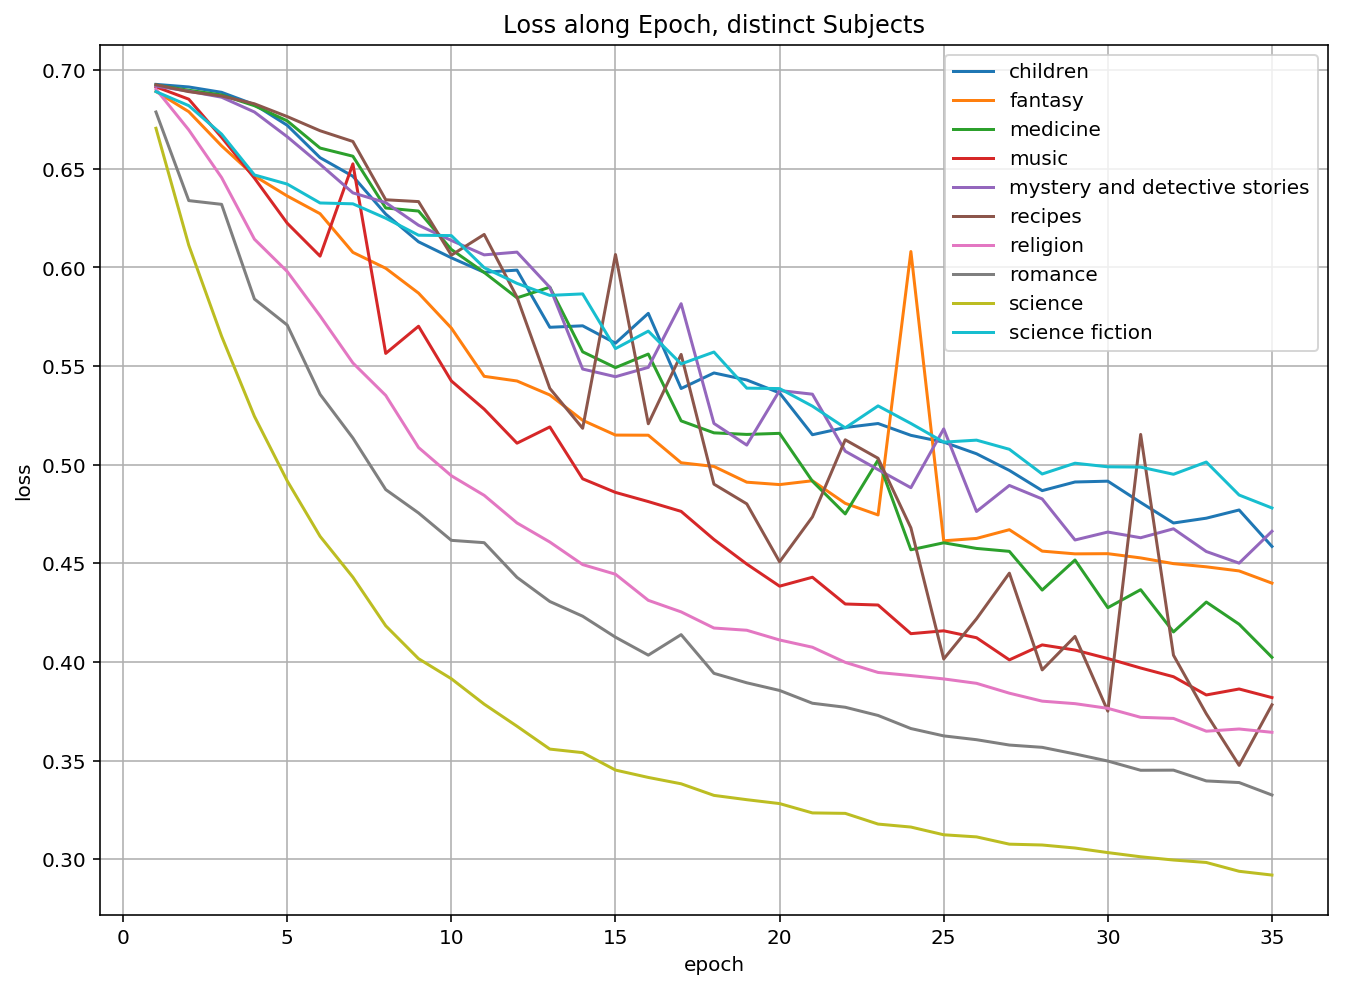

In [64]:
for subj in subj_list:
    plt.plot(np.array(range(1, 36)), history_subj[subj]['loss'], \
             label= subj )
 
plt.title('Loss along Еpoch, distinct Subjects')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
fig.savefig('Loss along Еpoch LSTM', dpi =300)
plt.show()

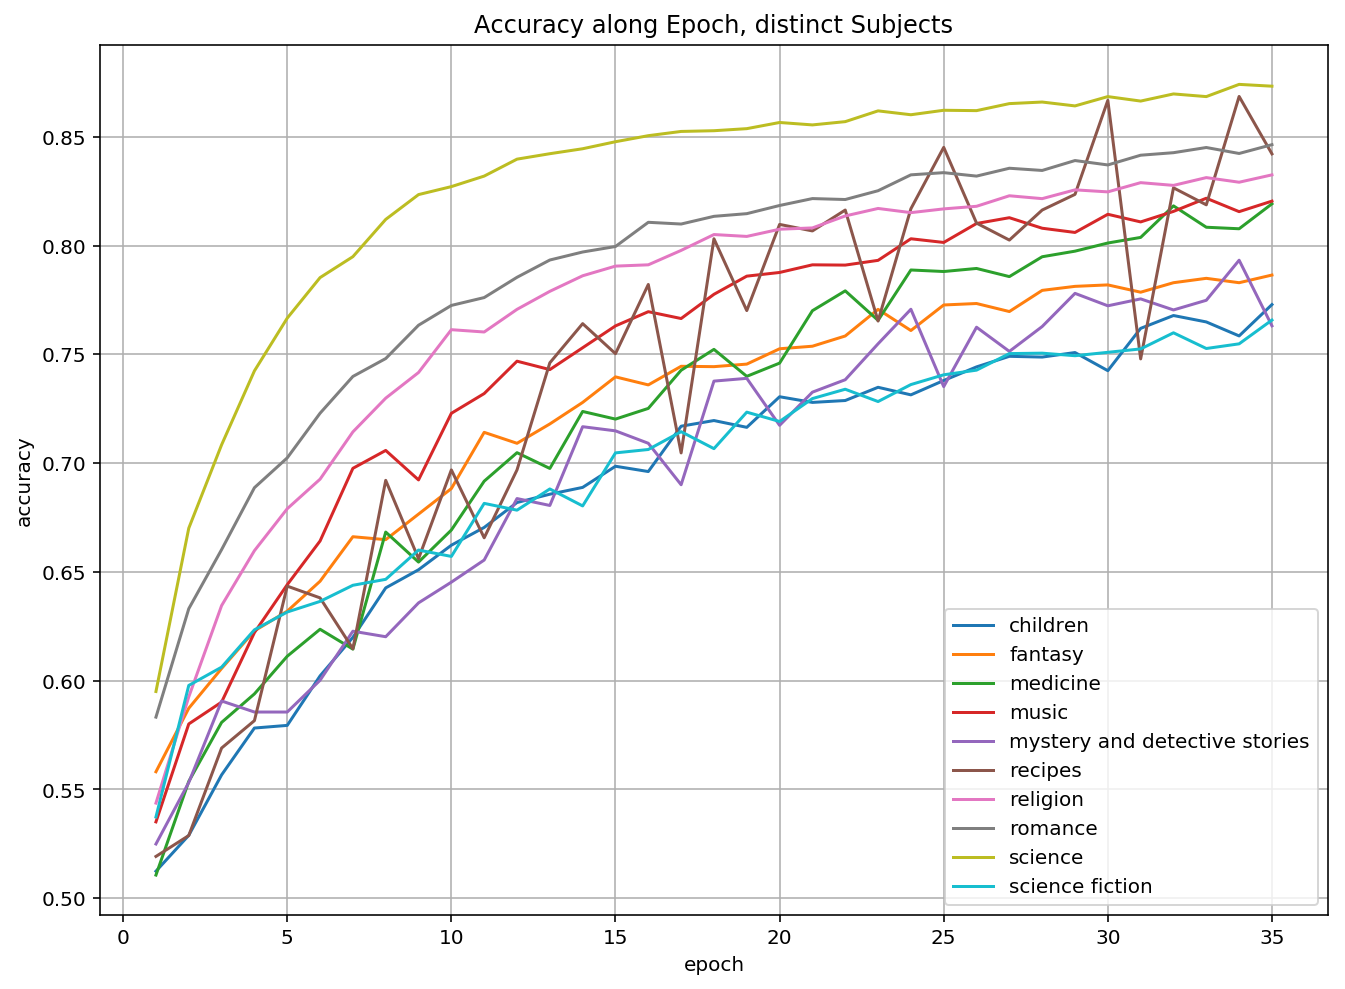

In [66]:
for subj in subj_list:
    plt.plot(np.array(range(1, 36)), history_subj[subj]['acc'], \
             label=subj)
plt.title('Accuracy along Epoch, distinct Subjects')
plt.legend(loc="lower right")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.show()